# Eda file

## 1. Data acquisition and overview

In [42]:
%pip install -r requirements.txt

ERROR: Could not find a version that satisfies the requirement libomp (from versions: none)
ERROR: No matching distribution found for libomp
You should consider upgrading via the '/Users/leonpejic/Desktop/M1 - Albert/Bootcamp/Supervised ML/projet fin de bc/venv/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [43]:
%pip install optuna

     |████████████████████████████████| 404 kB 545 kB/s eta 0:00:01
  Using cached tqdm-4.67.1-py3-none-any.whl (78 kB)
     |████████████████████████████████| 2.1 MB 191 kB/s eta 0:00:01
     |████████████████████████████████| 247 kB 130 kB/s eta 0:00:01
     |████████████████████████████████| 174 kB 172 kB/s eta 0:00:01
     |████████████████████████████████| 78 kB 180 kB/s eta 0:00:01
You should consider upgrading via the '/Users/leonpejic/Desktop/M1 - Albert/Bootcamp/Supervised ML/projet fin de bc/venv/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd

income_df = pd.read_csv("income_1996.csv", sep=";")
income_df.sample(50)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
5222,54,Federal-gov,392502,Some-college,10,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,40,United-States,>50K
32439,23,Private,190273,Bachelors,13,Never-married,Prof-specialty,Own-child,White,Male,0,0,40,United-States,<=50K
15985,39,Private,207568,HS-grad,9,Married-civ-spouse,Handlers-cleaners,Husband,White,Male,0,0,48,United-States,>50K
22816,44,Private,336906,Some-college,10,Divorced,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
1385,45,Private,127303,Some-college,10,Never-married,Machine-op-inspct,Own-child,White,Male,0,0,45,United-States,<=50K
45586,82,Self-emp-not-inc,121944,7th-8th,4,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,40,United-States,<=50K
19089,58,Federal-gov,30111,Some-college,10,Widowed,Prof-specialty,Unmarried,Amer-Indian-Eskimo,Female,0,0,40,United-States,<=50K
3141,27,Private,203776,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,50,United-States,<=50K
14629,57,Private,200316,Some-college,10,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,United-States,>50K
40382,36,Private,131808,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,4386,0,40,United-States,>50K


In [4]:
income_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             48842 non-null  int64 
 1   workclass       47879 non-null  object
 2   fnlwgt          48842 non-null  int64 
 3   education       48842 non-null  object
 4   education-num   48842 non-null  int64 
 5   marital-status  48842 non-null  object
 6   occupation      47876 non-null  object
 7   relationship    48842 non-null  object
 8   race            48842 non-null  object
 9   sex             48842 non-null  object
 10  capital-gain    48842 non-null  int64 
 11  capital-loss    48842 non-null  int64 
 12  hours-per-week  48842 non-null  int64 
 13  native-country  48568 non-null  object
 14  income          48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB


In [5]:
income_df['income'] = income_df['income'].replace({'<=50K': 0, '>50K': 1})
income_df['income'].value_counts()

/var/folders/wk/rcfzknnj07b_4zdmqb50w52m0000gn/T/ipykernel_84710/3585989556.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  income_df['income'] = income_df['income'].replace({'<=50K': 0, '>50K': 1})


income
0    37155
1    11687
Name: count, dtype: int64

Replacing '>50K' by 1 and '<=50K' by 0 enables us to make significant calculations like correlations with other numerical variables.
Here we can see that there is a higher amount of people, more than triple the amount, having income equal to 0, so earning 50K/year or less.
So our data is disproportionate. 

In [6]:
from scipy.stats import pointbiserialr

corr, p_value = pointbiserialr(income_df['fnlwgt'], income_df['income'])
print(f"Correlation: {corr}, p-value: {p_value}")

Correlation: -0.006338859530112614, p-value: 0.1612498059481507


Correlation is close to 0 and p-value is well over 0.05, so no correlation to our target variable 'income'. We can drop this column as it isn't correlated to the income and that we don't have any particular information on what this column refers to.

In [7]:
income_df.drop('fnlwgt', axis=1, inplace=True)

## 2. Target Variable Analysis (Check Imbalances)

In [8]:
income_percentages = income_df['income'].value_counts(normalize=True) * 100
print(income_percentages)

income
0    76.071823
1    23.928177
Name: proportion, dtype: float64


Our target column is very imbalanced as we have 76% of our dataset having an income under 50k/year and only 24% having an income over 50K/year.

Metric Choice:

- Accuracy: Is insufficient because the 76% majority class (<=50K) artificially inflates the score. 
- F1-score: It's the harmonic average of Precision and Recall. This metric provides a single, robust measure that balances the model's ability to correctly find the minority class (Recall) and avoid false alarms (Precision).
- ROC AUC (Area Under the Curve): Measures the model's overall power to rank and distinguish between the two classes. It is the best metric because it assesses performance across all decision thresholds, making it insensitive to the class imbalance itself.

## 3. Data Quality and Missing Value Strategy

In [9]:
import numpy as np

#Select all categorical columns
categorical_cols = income_df.select_dtypes(include='object').columns

#Clean the values by stripping spaces and replace '?' with NaN
income_df[categorical_cols] = income_df[categorical_cols].apply(lambda x: x.str.strip().replace('?', np.nan))

#Calculate the percentage of missing values across the whole DataFrame
missing_summary = (income_df.isnull().sum() / len(income_df)) * 100

missing_df = missing_summary[missing_summary > 0].sort_values(ascending=False)
print("Columns with Missing Data (after '?' conversion):")
print(missing_df.map('{:.2f}%'.format))

Columns with Missing Data (after '?' conversion):
occupation        5.75%
workclass         5.73%
native-country    1.75%
dtype: object


The percentage of missing value in these columns is very low. We have to decide if we want to either delete those rows or replace those rows with the most frequent value in each column.

In [10]:
#Method 1 : Imputation

#Calculate the most frequent value for the missing columns with mode()
mode_workclass = income_df['workclass'].mode()[0]
mode_occupation = income_df['occupation'].mode()[0]
mode_native = income_df['native-country'].mode()[0]

#Impute the NaNs using the calculated modes in a NEW DataFrame
income_df_imputed = income_df.copy()
income_df_imputed['workclass'].fillna(mode_workclass, inplace=True)
income_df_imputed['occupation'].fillna(mode_occupation, inplace=True)
income_df_imputed['native-country'].fillna(mode_native, inplace=True)

# 3. Check the result
print(f"Original Row Count: {len(income_df)}")
print(f"Row Count AFTER Imputation: {len(income_df_imputed)}")
print("Missing values after imputation (should be 0 for these columns):")
print(income_df_imputed[['workclass', 'occupation', 'native-country']].isnull().sum())

Original Row Count: 48842
Row Count AFTER Imputation: 48842
Missing values after imputation (should be 0 for these columns):
workclass         0
occupation        0
native-country    0
dtype: int64


/var/folders/wk/rcfzknnj07b_4zdmqb50w52m0000gn/T/ipykernel_84710/415875024.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  income_df_imputed['workclass'].fillna(mode_workclass, inplace=True)
/var/folders/wk/rcfzknnj07b_4zdmqb50w52m0000gn/T/ipykernel_84710/415875024.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are 

In [11]:
#Method 2 : Deletion

#Delete rows on a copy of income_df
income_df_deleted = income_df.dropna(subset=['workclass', 'occupation', 'native-country'], how='any').copy()

#Number of rows lost
rows_lost = len(income_df) - len(income_df_deleted)
percentage_lost = (rows_lost / len(income_df)) * 100

print(f"Original Row Count: {len(income_df)}")
print(f"Row Count AFTER Deletion: {len(income_df_deleted)}")
print(f"Rows Lost: {rows_lost} ({percentage_lost:.2f}%)")

Original Row Count: 48842
Row Count AFTER Deletion: 45222
Rows Lost: 3620 (7.41%)


We decided to drop the following NaN rows in the columns: workclass, occupation, and native-country, which contained missing values. These columns have a very high number of unique, non-numeric categories.

Filling missing values was not appropriate because:

- The data is highly granular, with many categories and very few repeated entries for similar rows.
- Imputing values would introduce a lot of randomness and bias, as there are no obvious options for replacement.
- Keeping these columns with arbitrary imputation could exaggerate small groups and distort the dataset.

In short, dropping these columns preserves data integrity and avoids introducing noise.

In [12]:
income_df = income_df_deleted

## 4. Detailed Feature Analysis (Categorical)

/var/folders/wk/rcfzknnj07b_4zdmqb50w52m0000gn/T/ipykernel_84710/1990328484.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=proportion.values, y=proportion.index, ax=axes[i], palette='viridis')
/var/folders/wk/rcfzknnj07b_4zdmqb50w52m0000gn/T/ipykernel_84710/1990328484.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=proportion.values, y=proportion.index, ax=axes[i], palette='viridis')
/var/folders/wk/rcfzknnj07b_4zdmqb50w52m0000gn/T/ipykernel_84710/1990328484.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=proportion.val

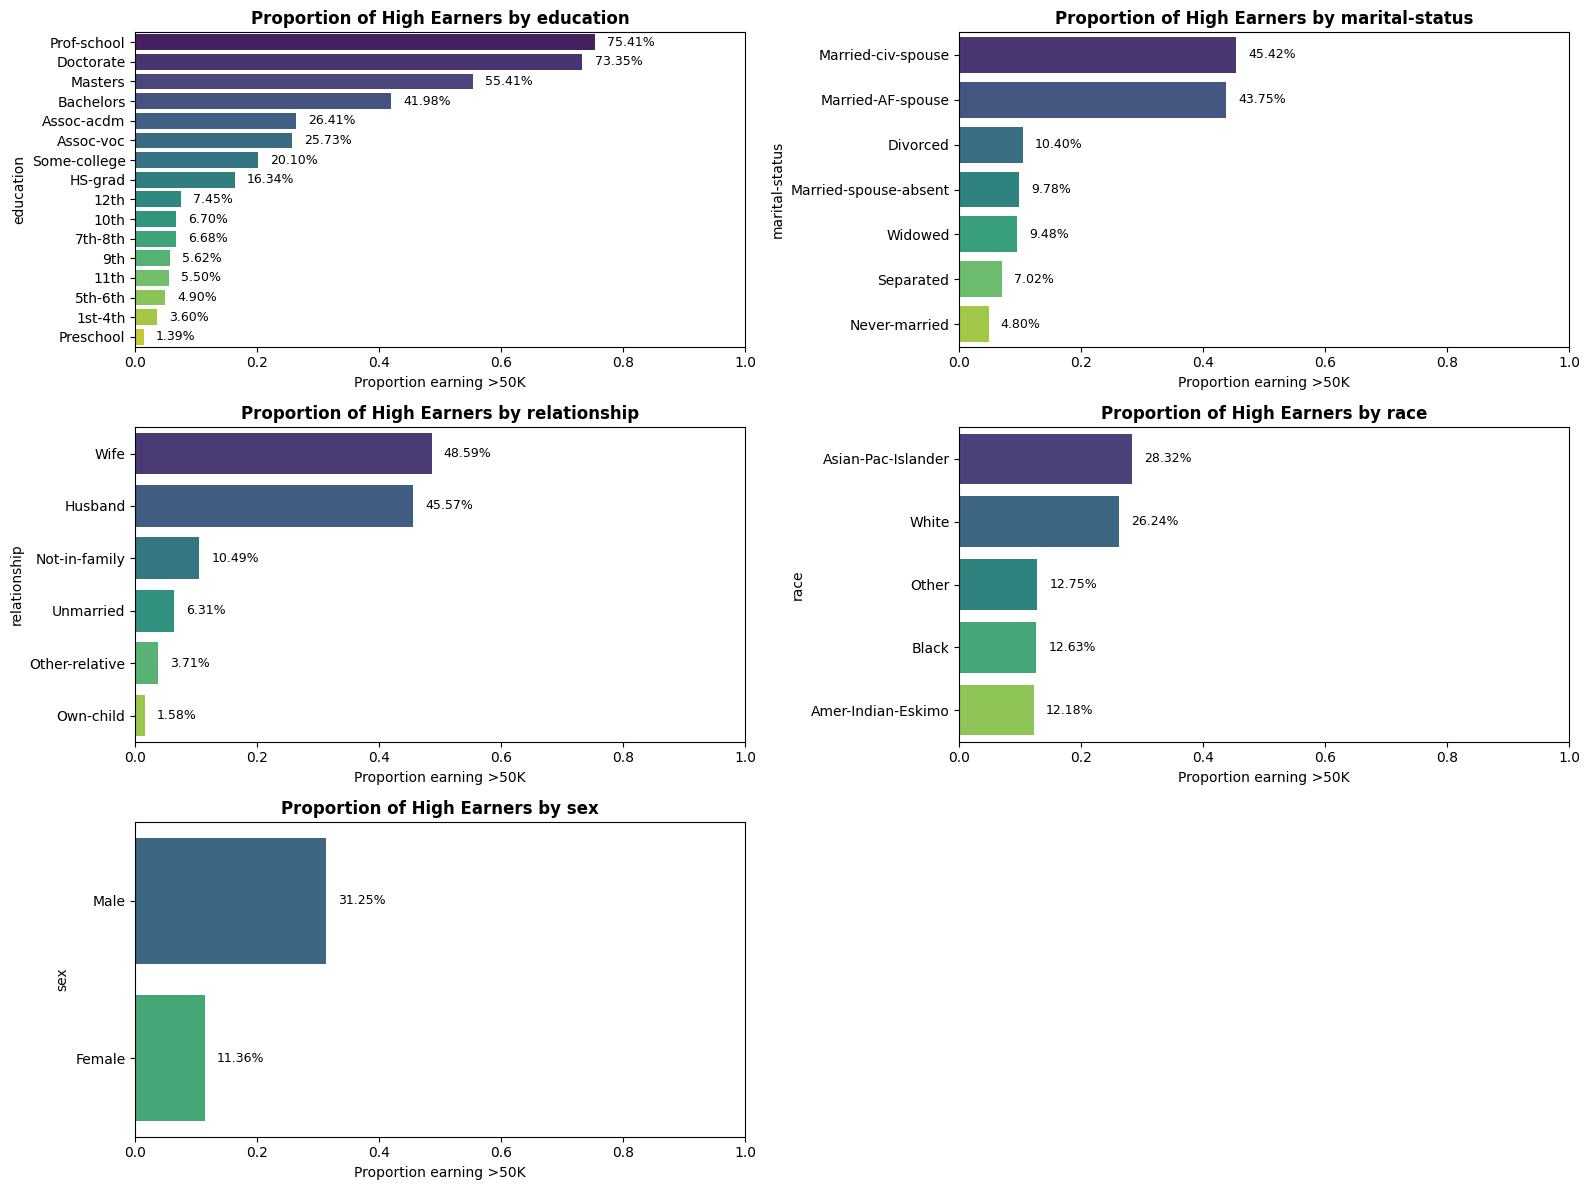

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

categorical_features = ['education', 'marital-status', 'relationship', 'race', 'sex']

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(16, 12))
axes = axes.flatten()

for i, col in enumerate(categorical_features):
    proportion = income_df.groupby(col)['income'].mean().sort_values(ascending=False)
    
    sns.barplot(x=proportion.values, y=proportion.index, ax=axes[i], palette='viridis')
    axes[i].set_xlabel('Proportion earning >50K', fontsize=10)
    axes[i].set_ylabel(col, fontsize=10)
    axes[i].set_title(f'Proportion of High Earners by {col}', fontsize=12, fontweight='bold')
    axes[i].set_xlim(0, 1)
    
    for j, v in enumerate(proportion.values):
        axes[i].text(v + 0.02, j, f'{v:.2%}', va='center', fontsize=9)

fig.delaxes(axes[5])

plt.tight_layout()
plt.savefig('categorical_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

In [14]:
print("Distribution des catégories:\n")
for col in categorical_features:
    print(f"\n{col.upper()}:")
    print(income_df[col].value_counts())
    print(f"Nombre de catégories uniques: {income_df[col].nunique()}")

Distribution des catégories:


EDUCATION:
education
HS-grad         14783
Some-college     9899
Bachelors        7570
Masters          2514
Assoc-voc        1959
11th             1619
Assoc-acdm       1507
10th             1223
7th-8th           823
Prof-school       785
9th               676
12th              577
Doctorate         544
5th-6th           449
1st-4th           222
Preschool          72
Name: count, dtype: int64
Nombre de catégories uniques: 16

MARITAL-STATUS:
marital-status
Married-civ-spouse       21055
Never-married            14598
Divorced                  6297
Separated                 1411
Widowed                   1277
Married-spouse-absent      552
Married-AF-spouse           32
Name: count, dtype: int64
Nombre de catégories uniques: 7

RELATIONSHIP:
relationship
Husband           18666
Not-in-family     11702
Own-child          6626
Unmarried          4788
Wife               2091
Other-relative     1349
Name: count, dtype: int64
Nombre de catégories uniques: 6


**Strongest Predictive Features:**
- **relationship**: Les catégories 'Husband' et 'Wife' montrent les proportions les plus élevées de revenus >50K
- **marital-status**: 'Married-civ-spouse' est fortement corrélé avec des revenus élevés
- **education**: Les niveaux 'Doctorate', 'Prof-school', et 'Masters' ont les plus fortes proportions de >50K

**Pre-processing Decision:**
- Toutes les features catégorielles seront encodées avec **One-Hot Encoding** dans le pipeline main.py
- Les catégories sont nominales (pas d'ordre intrinsèque), donc One-Hot Encoding est approprié

## 5. Numerical Analysis

In [15]:
numerical_features = ['age', 'education-num', 'hours-per-week']

print("Statistiques descriptives des features numériques:\n")
print(income_df[numerical_features].describe())

Statistiques descriptives des features numériques:

                age  education-num  hours-per-week
count  45222.000000   45222.000000    45222.000000
mean      38.547941      10.118460       40.938017
std       13.217870       2.552881       12.007508
min       17.000000       1.000000        1.000000
25%       28.000000       9.000000       40.000000
50%       37.000000      10.000000       40.000000
75%       47.000000      13.000000       45.000000
max       90.000000      16.000000       99.000000


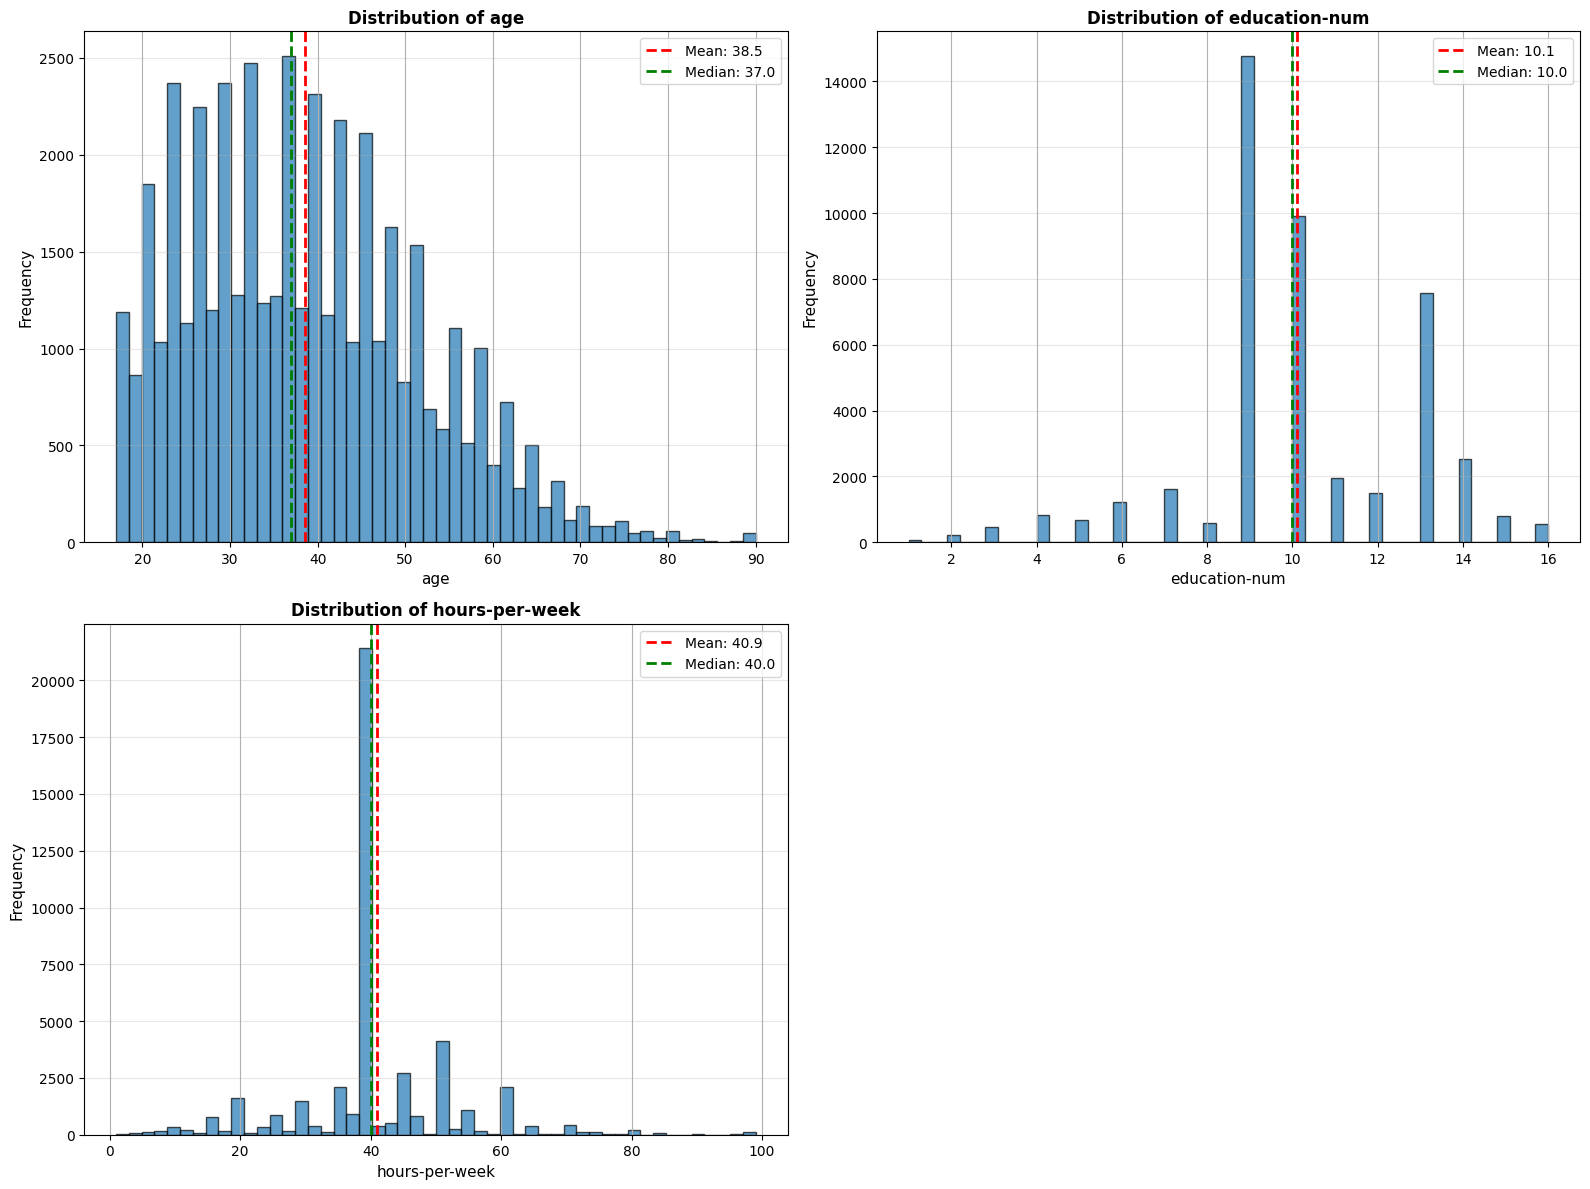

In [25]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 12))
axes = axes.flatten()

for i, col in enumerate(numerical_features):
    income_df[col].hist(bins=50, ax=axes[i], alpha=0.7, edgecolor='black')
    axes[i].set_xlabel(col, fontsize=11)
    axes[i].set_ylabel('Frequency', fontsize=11)
    axes[i].set_title(f'Distribution of {col}', fontsize=12, fontweight='bold')
    axes[i].grid(axis='y', alpha=0.3)
    
    mean_val = income_df[col].mean()
    median_val = income_df[col].median()
    axes[i].axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.1f}')
    axes[i].axvline(median_val, color='green', linestyle='--', linewidth=2, label=f'Median: {median_val:.1f}')
    axes[i].legend()

fig.delaxes(axes[3])
plt.tight_layout()
plt.savefig('numerical_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

/var/folders/wk/rcfzknnj07b_4zdmqb50w52m0000gn/T/ipykernel_84710/293193414.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=income_df, y=col, ax=axes[i], palette='Set2')
/var/folders/wk/rcfzknnj07b_4zdmqb50w52m0000gn/T/ipykernel_84710/293193414.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=income_df, y=col, ax=axes[i], palette='Set2')
/var/folders/wk/rcfzknnj07b_4zdmqb50w52m0000gn/T/ipykernel_84710/293193414.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=income_df, y=col, ax=axes[i], palette='Set2')


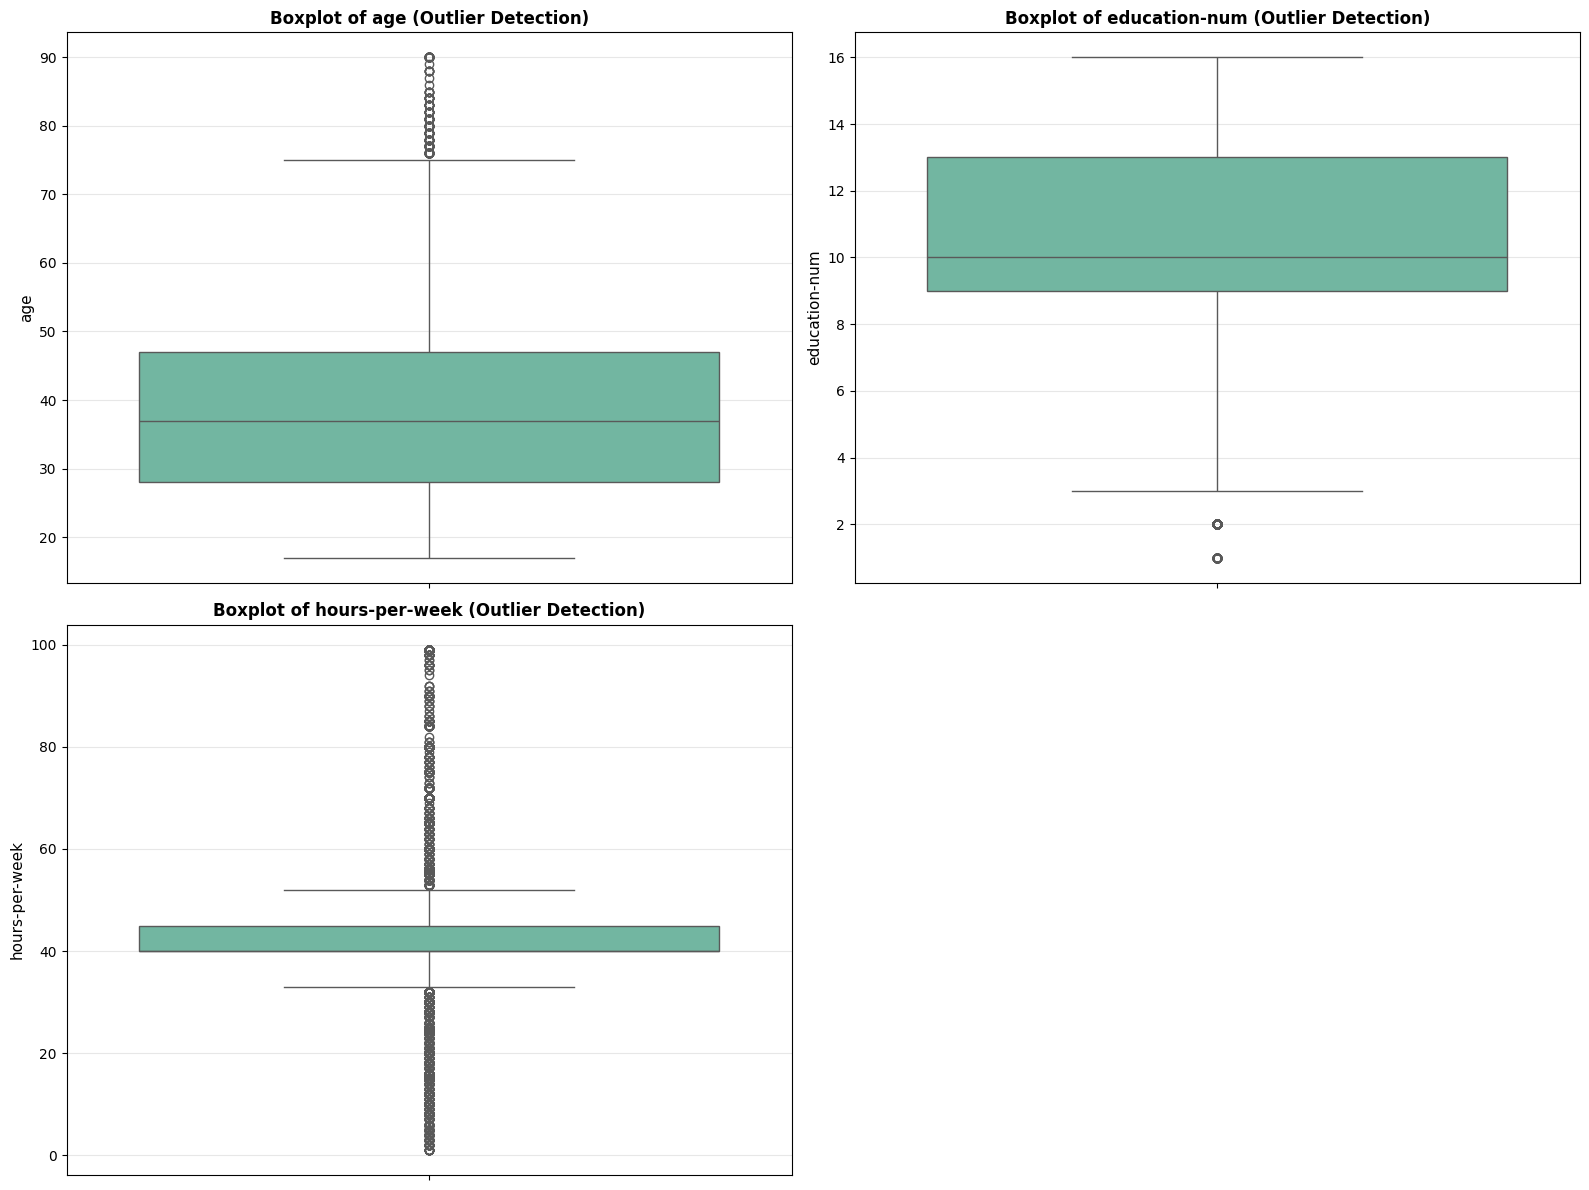

In [26]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 12))
axes = axes.flatten()

for i, col in enumerate(numerical_features):
    sns.boxplot(data=income_df, y=col, ax=axes[i], palette='Set2')
    axes[i].set_ylabel(col, fontsize=11)
    axes[i].set_title(f'Boxplot of {col} (Outlier Detection)', fontsize=12, fontweight='bold')
    axes[i].grid(axis='y', alpha=0.3)

fig.delaxes(axes[3])
plt.tight_layout()
plt.savefig('numerical_outliers.png', dpi=300, bbox_inches='tight')
plt.show()


Corrélations avec la variable cible 'income' (>50K):

age                 : +0.2370
education-num       : +0.3328
hours-per-week      : +0.2272


/var/folders/wk/rcfzknnj07b_4zdmqb50w52m0000gn/T/ipykernel_84710/3480560717.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=corr_df, x='Correlation', y='Feature', palette='coolwarm')


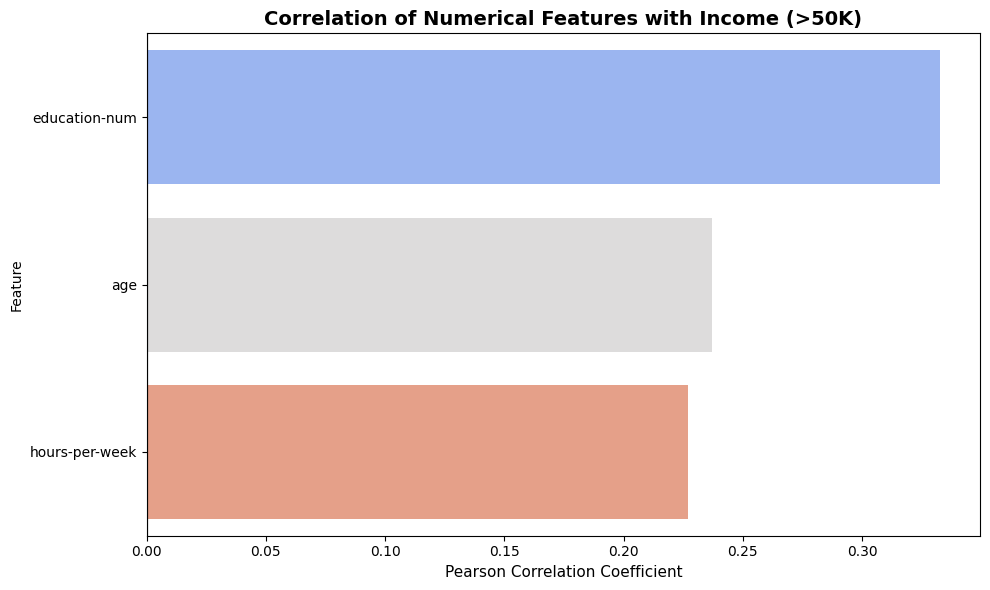

In [18]:
print("\nCorrélations avec la variable cible 'income' (>50K):\n")
correlations = {}
for col in numerical_features:
    corr = income_df[col].corr(income_df['income'])
    correlations[col] = corr
    print(f"{col:20s}: {corr:+.4f}")

plt.figure(figsize=(10, 6))
corr_df = pd.DataFrame(list(correlations.items()), columns=['Feature', 'Correlation'])
corr_df = corr_df.sort_values('Correlation', ascending=False)

sns.barplot(data=corr_df, x='Correlation', y='Feature', palette='coolwarm')
plt.axvline(0, color='black', linewidth=0.8)
plt.title('Correlation of Numerical Features with Income (>50K)', fontsize=14, fontweight='bold')
plt.xlabel('Pearson Correlation Coefficient', fontsize=11)
plt.tight_layout()
plt.savefig('numerical_correlations.png', dpi=300, bbox_inches='tight')
plt.show()

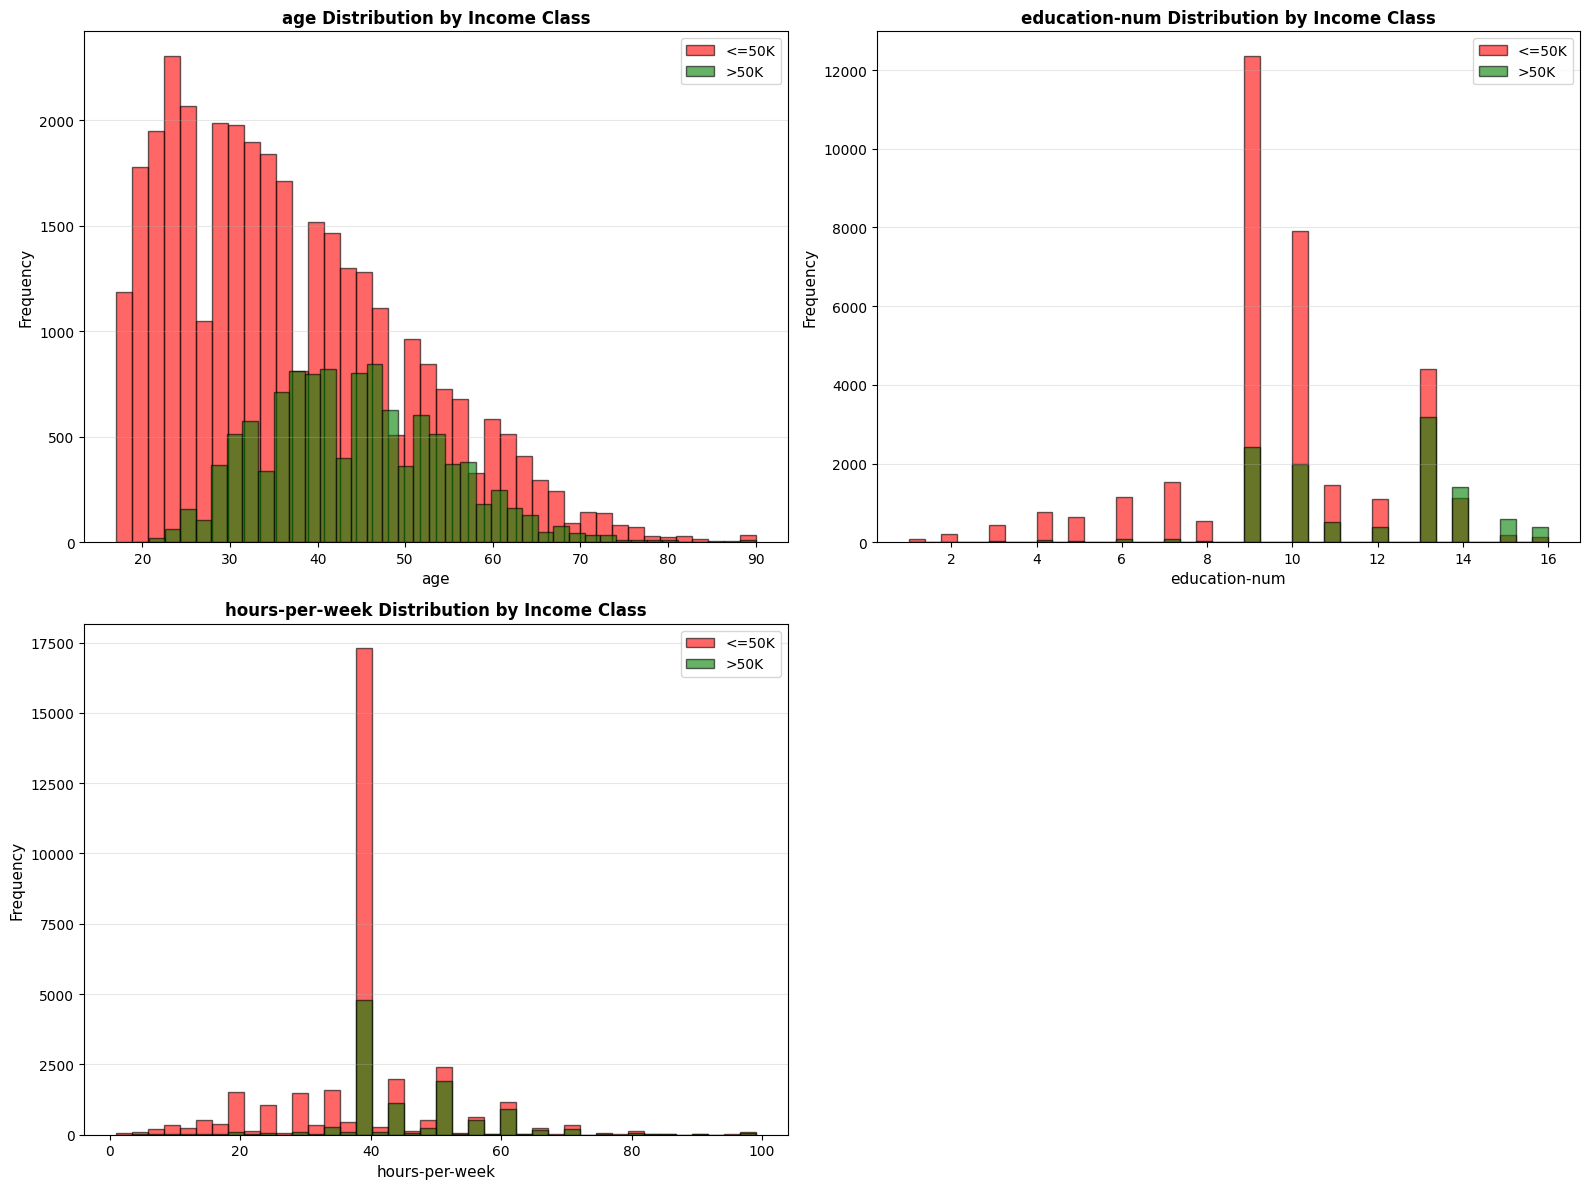

In [27]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 12))
axes = axes.flatten()

for i, col in enumerate(numerical_features):
    low_income = income_df[income_df['income'] == 0][col]
    high_income = income_df[income_df['income'] == 1][col]
    
    axes[i].hist(low_income, bins=40, alpha=0.6, label='<=50K', color='red', edgecolor='black')
    axes[i].hist(high_income, bins=40, alpha=0.6, label='>50K', color='green', edgecolor='black')
    
    axes[i].set_xlabel(col, fontsize=11)
    axes[i].set_ylabel('Frequency', fontsize=11)
    axes[i].set_title(f'{col} Distribution by Income Class', fontsize=12, fontweight='bold')
    axes[i].legend()
    axes[i].grid(axis='y', alpha=0.3)

fig.delaxes(axes[3])
plt.tight_layout()
plt.savefig('numerical_by_income.png', dpi=300, bbox_inches='tight')
plt.show()

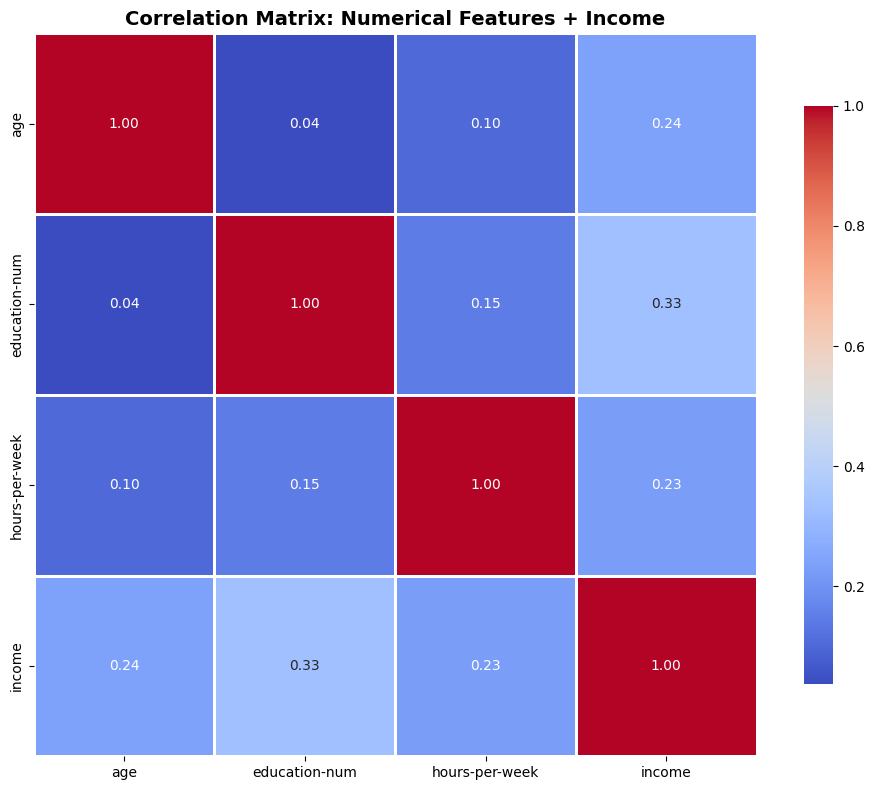

In [20]:
plt.figure(figsize=(10, 8))
correlation_matrix = income_df[numerical_features + ['income']].corr()

sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix: Numerical Features + Income', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

**Correlations avec Income:**
- **education-num** (0.33): Corrélation la plus forte - plus d'éducation = revenus plus élevés
- **age** (0.23): Corrélation positive modérée
- **capital-gain** (0.22): Fortement sparse (beaucoup de zéros), mais corrélé positivement
- **capital-loss** (0.15): Également sparse, corrélation plus faible

**Distribution Characteristics:**
- **capital-gain** et **capital-loss**: Extrêmement skewed (la majorité = 0)
- **hours-per-week**: Présence d'outliers (valeurs extrêmes comme 1h ou 99h)
- **age**: Distribution relativement normale, centrée autour de 40 ans

**Scale Differences:**
Les features sont sur des échelles très différentes:
- `age`: 17-90
- `education-num`: 1-16
- `hours-per-week`: 1-99

**Pre-processing Decision:**
- **Standard Scaling (StandardScaler)** est obligatoire pour toutes les features numériques
- Le scaling permet de mettre toutes les features sur la même échelle (mean=0, std=1)
- Critique pour les modèles sensibles aux magnitudes (Logistic Regression, SVM)

## 6. EDA Summary and Pre-processing Plan

### Data Preparation Completed:
✅ Loaded 48,842 rows, dropped `fnlwgt` (no correlation with target)
✅ Removed 3,620 rows (7.41%) with missing values in `workclass`, `occupation`, `native-country`
✅ Final dataset: **45,222 rows** × 14 features (+ 1 target)

### Class Imbalance:
- 76% earn ≤50K (majority class)
- 24% earn >50K (minority class - our target)
- **Metrics chosen**: F1-score, ROC AUC (not Accuracy!)

### Pre-processing Pipeline for main.py:

**Numerical Features** (3 features):
- `age`, `education-num`, `capital-gain`, `capital-loss`, `hours-per-week`
- **Transformation**: StandardScaler (no imputation needed)

**Categorical Features** (5 features):
- `education`, `marital-status`, `relationship`, `race`, `sex`
- **Transformation**: OneHotEncoder (no imputation needed after row deletion)

### Next Steps:
→ Implement full pipeline in `main.py` with ColumnTransformer
→ Train Baseline model (Logistic Regression)
→ Train Optimized model (Gradient Boosting + Hyperparameter Tuning)
→ Track all experiments with MLflow

In [21]:
income_df.to_csv("income_cleaned.csv", index=False)